In [1]:
# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

# Imorting required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing require AI/ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
# Location of the datasets
train_data=r'C:\Users\DELL\train_depression.csv'
test_data=r'C:\Users\DELL\test_depression.csv'

In [3]:
# Locading the datasets in memory
df_train=pd.read_csv(train_data)

### Missing Value Imputation

In [4]:
# Checking the % of null entries
df_train.isnull().sum()/len(df_train)*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

In [5]:
# It is observed that certain columns have very low missing value count like Financial Stress , Degree & Dietary Habits
# So here the missing value imputation can be done by using straight forward methods like mean , median or mode 
# For that it is necessary to find out their data types
df_train.dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [6]:
# Checking the Financial stress parameter --> It is clear that this column needs to be treated as a categorical variable
df_train['Financial Stress'].unique()

array([ 2.,  3.,  1.,  4.,  5., nan])

In [7]:
# Changing the data type of the Financial Stress to object
df_train['Financial Stress']=df_train['Financial Stress'].astype(object)

In [8]:
# Extracting the columns which have null values along with their data type
null_value_cols=[(col,round(100*null_values/len(df_train),2),df_train[col].dtype)
                 for col,null_values in df_train.isnull().sum().items() if null_values>0]

In [9]:
# Checking the null values along with their data types
null_value_cols

[('Profession', 26.03, dtype('O')),
 ('Academic Pressure', 80.17, dtype('float64')),
 ('Work Pressure', 19.84, dtype('float64')),
 ('CGPA', 80.17, dtype('float64')),
 ('Study Satisfaction', 80.17, dtype('float64')),
 ('Job Satisfaction', 19.84, dtype('float64')),
 ('Dietary Habits', 0.0, dtype('O')),
 ('Degree', 0.0, dtype('O')),
 ('Financial Stress', 0.0, dtype('O'))]

In [10]:
# I will extract the columns which have very low missing values
low_missing_values=[(col,dt) for col,missing_pct,dt in null_value_cols if missing_pct<1]

In [11]:
# Checking columns which have low missing value count and their dtypes
low_missing_values

[('Dietary Habits', dtype('O')),
 ('Degree', dtype('O')),
 ('Financial Stress', dtype('O'))]

In [12]:
# Imputing the missing values in the columns (with low missing values) and which are categorical in nature by using mode
for each_col,data_type in low_missing_values:
  df_train[each_col]=df_train[each_col].fillna(df_train[each_col].mode()[0])
  df_train[each_col]=df_train[each_col].astype(object)

In [13]:
# Checking the % of null entries
df_train.isnull().sum()/len(df_train)*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.000000
Degree                                    0.000000
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.000000
Family History of Mental Illness          0.000000
Depression                     

In [14]:
# I decided to write a function to identify the columns which very high percentage of missing values and then just imputing missing values by a place holder 
# But before going ahead I decided to check the nature of the columns with these high missing values
high_missing_values=[(col,dt) for col,missing_pct,dt in null_value_cols if missing_pct>50]
high_missing_values

[('Academic Pressure', dtype('float64')),
 ('CGPA', dtype('float64')),
 ('Study Satisfaction', dtype('float64'))]

In [15]:
#Just extracting the column names of the columns with high missing values
col_names_high_missing_value=[each_col for each_col,data_type in high_missing_values]

# Doing a quick analysis of the columns with high missing values 
def analyze_high_missing_value_columns(dataframe,high_missing_value_col):

  """
  This function will take data frame & the columns with high missing values.
    Then it will show the number of unique values in column with some statistical information of the selected column
    
    Args: Dataframe & columns with high missing values
    
    Returns : Unique values in the columns and statistics for the column
  """

  for each_col in high_missing_value_col:
    print(f'For {each_col}')
    print(f'The number of unique values are {dataframe[each_col].nunique()}' )
    print(f'The statistics are {dataframe[each_col].describe()}' )
    if dataframe[each_col].nunique()<=10:
      print(f'The unique values are {dataframe[each_col].unique()} \n')
    else:
      print('\n')
    


In [16]:
# Using the modular function to check the details for all columns with high missing values
analyze_high_missing_value_columns(df_train,col_names_high_missing_value)

For Academic Pressure
The number of unique values are 5
The statistics are count    27897.000000
mean         3.142273
std          1.380457
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Academic Pressure, dtype: float64
The unique values are [nan  5.  2.  3.  4.  1.] 

For CGPA
The number of unique values are 331
The statistics are count    27898.000000
mean         7.658636
std          1.464466
min          5.030000
25%          6.290000
50%          7.770000
75%          8.920000
max         10.000000
Name: CGPA, dtype: float64


For Study Satisfaction
The number of unique values are 5
The statistics are count    27897.000000
mean         2.944940
std          1.360197
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Study Satisfaction, dtype: float64
The unique values are [nan  2.  5.  3.  4.  1.] 



In [17]:
# Making small bins of the CGPA 
def CGPA_BIN(CGPA_VALUE):
  if CGPA_VALUE<5:
    return "Less than 5"
  elif CGPA_VALUE>=5 and CGPA_VALUE<=6:
    return "5-6"
  elif CGPA_VALUE>=6 and CGPA_VALUE<=7:
    return "6-7"
  elif CGPA_VALUE>=7 and CGPA_VALUE<=8:
    return "7-8"
  elif CGPA_VALUE>=8 and CGPA_VALUE<=9:
    return "8-9"
  elif CGPA_VALUE>=9 and CGPA_VALUE<=10:
    return "9-10"  

In [18]:
# Replacing the CGPA column
df_train.CGPA=df_train.CGPA.apply(lambda x : CGPA_BIN(x))

In [19]:
# It is also clear that the Study satisfaction & the academic pressure needs to be treated as a categorical variable
df_train['Academic Pressure']=df_train['Academic Pressure'].astype(object)
df_train['Study Satisfaction']=df_train['Study Satisfaction'].astype(object)

In [20]:
# Now replacing the missing values in Study satisfaction, CGPA & the academic pressure with "Missing Value"
df_train['Academic Pressure']=df_train['Academic Pressure'].fillna("Missing_Value")
df_train['Study Satisfaction']=df_train['Study Satisfaction'].fillna("Missing_Value")
df_train['CGPA']=df_train['CGPA'].fillna("Missing_Value")

In [21]:
# Here I decided to first preprocess the columns which do not have any missing values &
# Then use them to predict the columns which had missing values 
# Checking the % of null entries
col_series=df_train.isnull().sum()/len(df_train)*100
col_series=[col for col,missing_value in col_series.items() if missing_value==0 ]

# De selecting the columns which will not have much significance
col_series=[col for col in col_series if col not in ['Depression','id','Name']]

In [22]:
# Making a dataframe for preprocssing
df_for_missing_val_imputation=df_train[col_series]

In [23]:
# Chceking the first 5 rows
df_for_missing_val_imputation.head()

,Gender,Age,City,Working Professional or Student,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Female,49.0,Ludhiana,Working Professional,Missing_Value,Missing_Value,Missing_Value,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,Male,26.0,Varanasi,Working Professional,Missing_Value,Missing_Value,Missing_Value,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,Male,33.0,Visakhapatnam,Student,5.0,8-9,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,Male,22.0,Mumbai,Working Professional,Missing_Value,Missing_Value,Missing_Value,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,Female,30.0,Kanpur,Working Professional,Missing_Value,Missing_Value,Missing_Value,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes


In [24]:
# Checking the dtypes again
df_for_missing_val_imputation.dtypes

Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Academic Pressure                         object
CGPA                                      object
Study Satisfaction                        object
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
dtype: object

In [25]:
# Checking the number of unique values per column in the given dataframe 
df_for_missing_val_imputation.nunique()

Gender                                     2
Age                                       43
City                                      98
Working Professional or Student            2
Academic Pressure                          6
CGPA                                       6
Study Satisfaction                         6
Sleep Duration                            36
Dietary Habits                            23
Degree                                   115
Have you ever had suicidal thoughts ?      2
Work/Study Hours                          13
Financial Stress                           5
Family History of Mental Illness           2
dtype: int64

### I have decided to use the frequency encoding to encode the columns which have high cardinality & use catboost

In [26]:
# The columns with clear high cardinality are where the unique values are above 20 
# Also the columns which I decided to short list for the analysis of whether to use frequncy encoding depended the data data type
col_for_freq_encoding=[col for col in df_for_missing_val_imputation.columns if (df_for_missing_val_imputation[col].nunique()>20) and (df_for_missing_val_imputation[col].dtype==object) ]

In [27]:
# Printing unique values in each column of dataframe
for col in col_for_freq_encoding:
  print(f'The {col} has below given unique values \n {df_for_missing_val_imputation[col].unique()} \n \n')

The City has below given unique values 
 ['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Vadodara' 'Vasai-Virar' 'Delhi'
 'Bhopal' 'Indore' 'Ishanabad' 'Vidhi' 'Ayush' 'Gurgaon' 'Krishna'
 'Aishwarya' 'Keshav' 'Harsha' 'Nalini' 'Aditya' 'Malyansh' 'Raghavendra'
 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'Nandini' 'M.Com' 'Plata'
 'Atharv' 'Pratyush' 'City' '3.0' 'Less than 5 Kalyan' 'MCA' 'Mira'
 'Moreadhyay' 'Morena' 'Ishkarsh' 'Kashk' 'Mihir' 'Vidya' 'Tolkata' 'Anvi'
 'Krinda' 'Ayansh' 'Shrey' 'Ivaan' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kashish' 'Kibara' 'Vaishnavi' 'Chhavi' 'Parth' 'Mahi' 'Tushar' 'MSc'
 'No' 'Rashi' 'ME' 'Molkata' 'Researcher' 'Kagan' 'Armaan' 'Ithal'
 'Nalyan' 'Dhruv' 'Galesabad' 'Itheg' 'Aaradhya' 'Pooja' 'Khushi'
 'Khaziabad' 'Jhanvi' 'Unirar'] 
 

The Sleep D

In [28]:
# Further analysing the columns which have high cardinality
for col in col_for_freq_encoding:
  print(f'The top 5 contributors for {col} are \n {(df_for_missing_val_imputation[col].value_counts()/len(df_for_missing_val_imputation)).head()} \n')

The top 5 contributors for City are 
 Kalyan         0.046844
Patna          0.042104
Vasai-Virar    0.040974
Kolkata        0.040434
Ahmedabad      0.039893
Name: City, dtype: float64 

The top 5 contributors for Sleep Duration are 
 Less than 5 hours    0.275650
7-8 hours            0.262751
More than 8 hours    0.232594
5-6 hours            0.228443
3-4 hours            0.000085
Name: Sleep Duration, dtype: float64 

The top 5 contributors for Dietary Habits are 
 Moderate     0.353298
Unhealthy    0.328550
Healthy      0.317989
Yes          0.000014
No           0.000014
Name: Dietary Habits, dtype: float64 

The top 5 contributors for Degree are 
 Class 12    0.104698
B.Ed        0.083092
B.Arch      0.062132
B.Com       0.057662
B.Pharm     0.041620
Name: Degree, dtype: float64 



In [29]:
# Based upon the above observations I decided to use one hot encoding for the Dietary habits and Sleep Duration
sleep_duration=list(df_for_missing_val_imputation['Sleep Duration'].value_counts().keys()[:4])
dietary_habits=list(df_for_missing_val_imputation['Dietary Habits'].value_counts().keys()[:3])

In [30]:
# Defining a function to handle the sleep duration & the dietray habits column
def sleep_diet_update(entry,ref_list):
  if entry in ref_list:
    return entry
  else:
    return 'Others'

In [31]:
# Updating the sleep duration and dietary habits columns
df_for_missing_val_imputation['Sleep Duration']=df_for_missing_val_imputation['Sleep Duration'].apply(lambda x:sleep_diet_update(x,sleep_duration))
df_for_missing_val_imputation['Dietary Habits']=df_for_missing_val_imputation['Dietary Habits'].apply(lambda x:sleep_diet_update(x,dietary_habits))

In [32]:
# Starting the frequency encoding
freq_degree=df_for_missing_val_imputation['Degree'].value_counts()
freq_city=df_for_missing_val_imputation['City'].value_counts()

# Mapping the frequesncy
df_for_missing_val_imputation['Degree']=df_for_missing_val_imputation['Degree'].map(freq_degree)
df_for_missing_val_imputation['City']=df_for_missing_val_imputation['City'].map(freq_city)

In [33]:
# Checking the unique values once again
df_for_missing_val_imputation.nunique()

Gender                                    2
Age                                      43
City                                     35
Working Professional or Student           2
Academic Pressure                         6
CGPA                                      6
Study Satisfaction                        6
Sleep Duration                            5
Dietary Habits                            4
Degree                                   32
Have you ever had suicidal thoughts ?     2
Work/Study Hours                         13
Financial Stress                          5
Family History of Mental Illness          2
dtype: int64

In [34]:
# Checking the data types once again
df_for_missing_val_imputation.dtypes

Gender                                    object
Age                                      float64
City                                       int64
Working Professional or Student           object
Academic Pressure                         object
CGPA                                      object
Study Satisfaction                        object
Sleep Duration                            object
Dietary Habits                            object
Degree                                     int64
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
dtype: object

In [35]:
# Now making a list of columns which I will be using to make dummy columns
dummy_cols=[col for col in df_for_missing_val_imputation.columns if df_for_missing_val_imputation[col].dtype==object]

In [36]:
# Making a dataframe with dummy columns
df_dummies=pd.get_dummies(data=df_for_missing_val_imputation,columns=dummy_cols,drop_first=True)

In [37]:
# Taking the variables which are float and then using the scaler on them
float_cols=[col for col in df_for_missing_val_imputation.columns if df_for_missing_val_imputation[col].dtype==float]

In [38]:
float_cols

['Age', 'Work/Study Hours']

In [39]:
### The below given graphs will be automated in upcoming revisions so that there will be no need to plot them separately

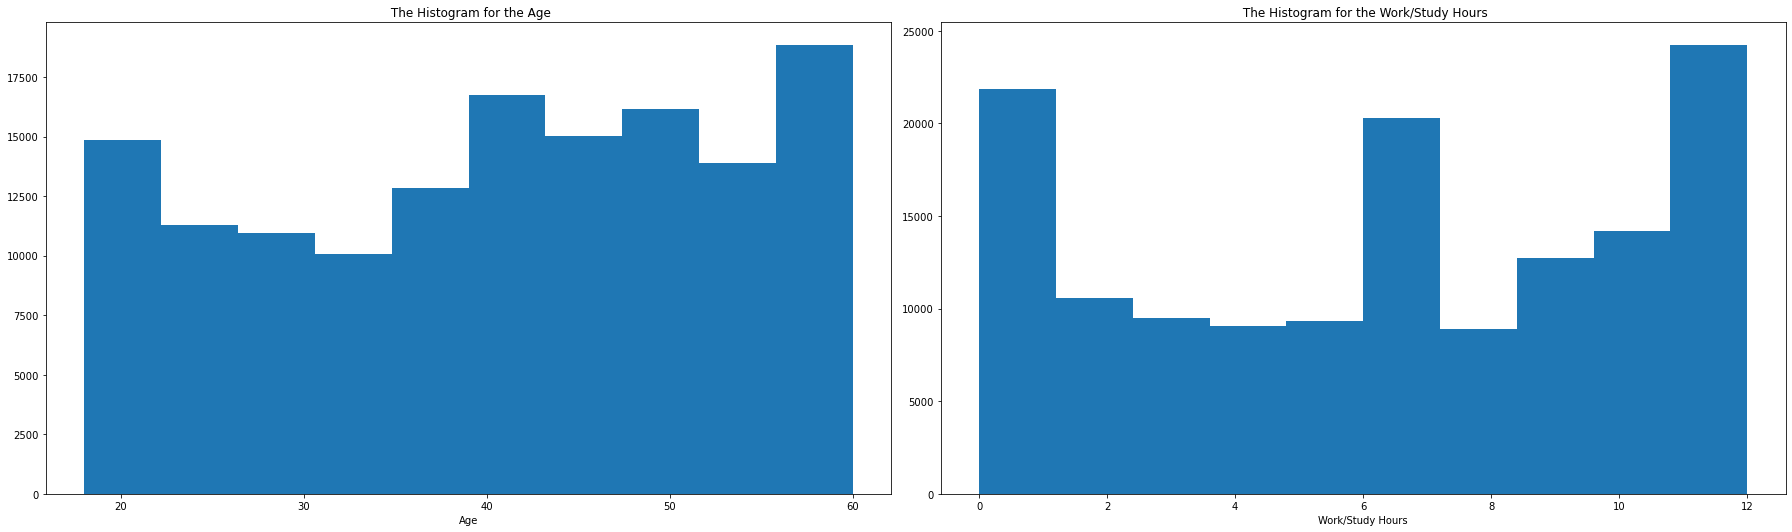

In [40]:
# Making a quick "for" loop to chake the distribution of all the numerical variables to decide which scaler to use
col_no=2
row_no=(len(float_cols)+1)//col_no
fig,axes=plt.subplots(nrows=row_no,ncols=col_no,figsize=(25,7.5))
axes=axes.flatten()

# Iterating through each col and then plotting the histogram
for col_num,col in enumerate(float_cols):
  ax=axes[col_num]
  ax.hist(x=df_dummies[col],bins=10)
  ax.set_title(f" The Histogram for the {col}")
  ax.set_xlabel(f'{col}')

# Deleting the unused plots
for col_to_del in range(col_num+1,len(float_cols)):
  fig.delaxes(ax=axes[col_num])

plt.tight_layout()
plt.show()


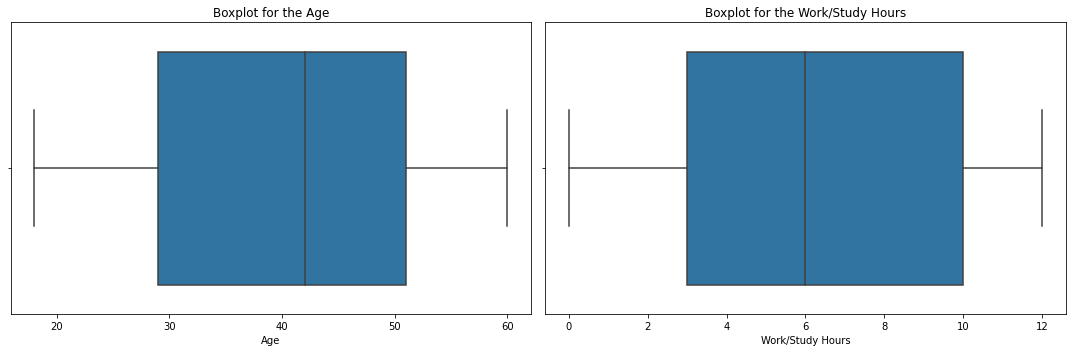

In [41]:
# Making a quick "for" loop to iterate through the continuous variable columns and then plotting their boxplot to check for outliers

col_no=2
row_no=(len(float_cols)+1)//2
fig,axes=plt.subplots(nrows=row_no,ncols=col_no,figsize=(15,5))
axes=axes.flatten()

# Iterating through each col and then plotting the boxplot
for col_num,col in enumerate(float_cols):
  sns.boxplot(ax=axes[col_num],data=df_dummies,x=col)
  axes[col_num].set_title(f"Boxplot for the {col}")

# Deleting the unused subplots
for col_to_del in range(col_num+1,len(float_cols)):
  fig.delaxes(ax=axes[col_to_del])

plt.tight_layout()
plt.show()



In [42]:
# Using the MinMax scaler as the data in the columns do not follow normal distribution and does not have outliers
scaler=MinMaxScaler()